# Presas en Nuevo León

(EDIT DESCRIPTION)

This notebook joins ndvi (res10), ndmi (res10) and marginalization (res8 to res10 through centroids) and creates categories for NDVI and marg in order to create the following analysis:

Analysis 1: (CSV) Average ndvi and ndmi min, median, mean, max data by marginalization group.

Analysis 2: (MAP, BOXPLOT) Zones that may recieve irrigation within urban spaces and its relation with marginalization. Places without vegetation are discarted.(ndvi without locations with water, marshy surfaces, artificial structures, rocks adn clouds).

Analysis 3: (CSV) From analisis 2, ndmi_diff (humidity variation/conservation) extremes (10%max, 10%min) are located, ploted and exported to csv.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [3]:
#Save csvs to output>____?
#csv_dataset = False 

#Save figures to output>____?
save_plots = False

## Data download

Data download

In [4]:
nuevoleon_originalsubset = gpd.read_file("../../../data/external/temporal_todocker/NuevoLeonSubset_original.csv")

#Review result
print(nuevoleon_originalsubset.shape)
nuevoleon_originalsubset.head(2)

(18152, 25)


,idmonitoreodiario,fechamonitoreo,clavesih,nombreoficial,nombrecomun,estado,nommunicipio,regioncna,latitud,longitud,...,bordolibre,nameelev,namealmac,namoelev,namoalmac,alturacortina,elevacionactual,almacenaactual,llenano,geometry
0,1928953,11/02/2021,PSANL,"Salinillas, N.L.","Salinillas, N.L.",Nuevo LeÃƒÂ³n,AnÃƒÂ¡huac,RÃƒÂ­o Bravo,27.429167,-100.372222,...,0,232,19.01099968,232,19.01099968,10,229.57,8.574,0.451002059,None
1,1928955,11/02/2021,LBCNL,"Rodrigo GÃƒÂ³mez, N.L.","La Boca, N.L.",Nuevo LeÃƒÂ³n,Santiago,RÃƒÂ­o Bravo,25.428056,-100.128056,...,0.839988,449.2000122,42.657,448.54,39.49,34,446.57,30.741,0.778450241,None


## Data treatment

### Data treatment - Set names for reservoirs

Names of reservoirs

In [5]:
nuevoleon_originalsubset['clavesih'].unique()

array(['PSANL', 'LBCNL', 'CCHNL', 'CPRNL', 'CCHNL          ',
       'CPRNL          ', 'LBCNL          ', 'PSANL          '],
      dtype=object)

Re-name reservoirs

In [6]:
def name_fromclave(clavesih):
    if (clavesih == 'PSANL' or clavesih == 'PSANL          '):
        return 'presa_salinillas'
    elif (clavesih == 'LBCNL' or clavesih == 'LBCNL          '):
        return 'presa_laboca'
    elif (clavesih == 'CPRNL' or clavesih == 'CPRNL          '):
        return 'presa_cerroprieto'
    elif (clavesih == 'CCHNL' or clavesih == 'CCHNL          '):
        return 'presa_elcuchillo'
    else:
          return "N/A"

nuevoleon_originalsubset['city'] = nuevoleon_originalsubset['clavesih'].apply(lambda x: name_fromclave(x))

#Review result
nuevoleon_originalsubset['city'].unique()

array(['presa_salinillas', 'presa_laboca', 'presa_elcuchillo',
       'presa_cerroprieto'], dtype=object)

### Data treatment - Filter for usefull data

Filter for reservoirs of interest

In [16]:
reservoirs_ofinterest = ['presa_laboca', 'presa_cerroprieto','presa_elcuchillo']

nuevoleon_originalsubset_f = nuevoleon_originalsubset.loc[nuevoleon_originalsubset['city'].isin(reservoirs_ofinterest)]
                                                           
#Review result
nuevoleon_originalsubset_f['city'].unique()

array(['presa_laboca', 'presa_elcuchillo', 'presa_cerroprieto'],
      dtype=object)

Filter for columns of interest

In [17]:
columns_tokeep = ['fechamonitoreo','clavesih','uso','elevcorona','bordolibre','nameelev','namealmac','namoelev','namoalmac','elevacionactual','almacenaactual','llenano','latitud','longitud','city']
nuevoleon_treatment = nuevoleon_originalsubset_f[columns_tokeep]

#Review result
print(nuevoleon_treatment.shape)
nuevoleon_treatment.head(2)

(13614, 15)


,fechamonitoreo,clavesih,uso,elevcorona,bordolibre,nameelev,namealmac,namoelev,namoalmac,elevacionactual,almacenaactual,llenano,latitud,longitud,city
1,11/02/2021,LBCNL,AP,450.04,0.839988,449.2000122,42.657,448.54,39.49,446.57,30.741,0.778450241,25.428056,-100.128056,presa_laboca
2,11/02/2021,CCHNL,AP/RI,169.2,3,166.6600037,1784.292,162.35,1123.143,158.38,685.752,0.610565173,25.711667,-99.276944,presa_elcuchillo


### Data treatment - Set datetime format

In [18]:
#Creates datetime data
nuevoleon_treatment.loc[:,'date'] = pd.to_datetime(nuevoleon_treatment['fechamonitoreo'],dayfirst=True)
nuevoleon_treatment.loc[:, 'month'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%m')).astype('int64')
nuevoleon_treatment.loc[:,'year'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%y')).astype('int64')
nuevoleon_treatment.loc[:,'yearmonth'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%Y-%m'))

#Reordering columns
columns_tokeep = ['date','month','year','yearmonth','city','uso','elevcorona','bordolibre','nameelev','namealmac','namoelev','namoalmac','elevacionactual','almacenaactual','llenano','latitud','longitud']
presas_nuevoleon = nuevoleon_treatment[columns_tokeep]

#Review result
print(presas_nuevoleon.shape)
presas_nuevoleon.head(2)

/tmp/ipykernel_1098/3022744329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevoleon_treatment.loc[:,'date'] = pd.to_datetime(nuevoleon_treatment['fechamonitoreo'],dayfirst=True)
/tmp/ipykernel_1098/3022744329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevoleon_treatment.loc[:, 'month'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%m')).astype('int64')
/tmp/ipykernel_1098/3022744329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

(13614, 17)


/tmp/ipykernel_1098/3022744329.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevoleon_treatment.loc[:,'yearmonth'] = nuevoleon_treatment['date'].apply(lambda x: x.strftime('%Y-%m'))


,date,month,year,yearmonth,city,uso,elevcorona,bordolibre,nameelev,namealmac,namoelev,namoalmac,elevacionactual,almacenaactual,llenano,latitud,longitud
1,2021-02-11,2,21,2021-02,presa_laboca,AP,450.04,0.839988,449.2000122,42.657,448.54,39.49,446.57,30.741,0.778450241,25.428056,-100.128056
2,2021-02-11,2,21,2021-02,presa_elcuchillo,AP/RI,169.2,3,166.6600037,1784.292,162.35,1123.143,158.38,685.752,0.610565173,25.711667,-99.276944


### Data treatment - Explore data from La Boca (High namoalmac variation)

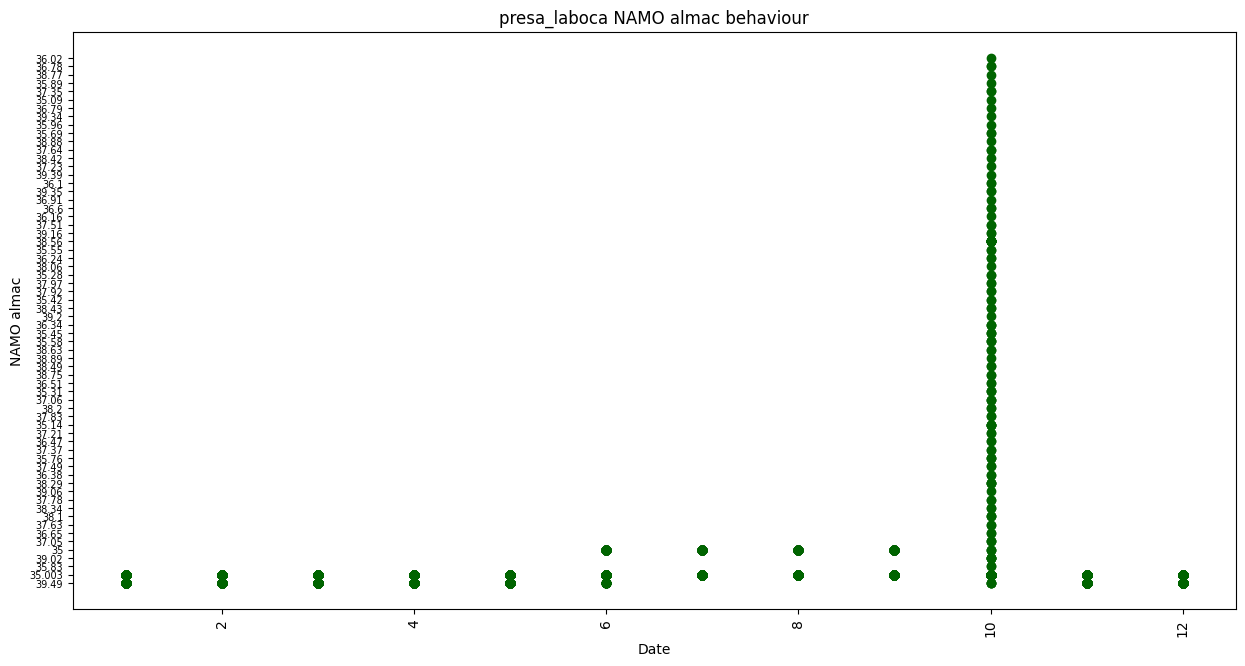

In [19]:
#Dam
city = 'presa_laboca'
presa_gdf = presas_nuevoleon.loc[presas_nuevoleon.city==city]

#Plot
plt.figure(figsize=(15,7.5))
plt.scatter(presa_gdf['month'],presa_gdf['namoalmac'], color = 'darkgreen',linewidth = 1);

# ---------- Format ----------
# Format - Titles
plt.title('{} NAMO almac behaviour'.format(city))
plt.xlabel('Date')
plt.ylabel('NAMO almac')

# Format - x ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(10)

# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)

## Data comparison

### Data comparison - Data of current subset from 2016

In [20]:
historical_behaviour = pd.DataFrame()  

for city in presas_nuevoleon.city.unique():

    presa_gdf = presas_nuevoleon.loc[(presas_nuevoleon.city == city) &
                                   (presas_nuevoleon.year>= 16)]

    presa_gdf.loc[:,'almacenaactual'] = presa_gdf['almacenaactual'].astype('float')
    presa_gdf.loc[:,'elevacionactual'] = presa_gdf['elevacionactual'].astype('float')


    summary = presa_gdf.groupby('yearmonth').agg({'almacenaactual':np.mean,'elevacionactual':np.mean})
    summary['city'] = city
    summary = summary.reset_index()

    historical_behaviour = pd.concat([historical_behaviour,summary])
    

#Delete Salinillas
historical_behaviour = historical_behaviour.loc[(historical_behaviour.city == 'presa_laboca') |
                                                (historical_behaviour.city == 'presa_cerroprieto') |
                                                (historical_behaviour.city == 'presa_elcuchillo')]

#Show
historical_behaviour

/tmp/ipykernel_1098/204032519.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presa_gdf.loc[:,'almacenaactual'] = presa_gdf['almacenaactual'].astype('float')
/tmp/ipykernel_1098/204032519.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  presa_gdf.loc[:,'almacenaactual'] = presa_gdf['almacenaactual'].astype('float')
/tmp/ipykernel_1098/204032519.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,yearmonth,almacenaactual,elevacionactual,city
0,2016-01,31.243933,446.688667,presa_laboca
1,2016-02,30.005346,446.396154,presa_laboca
2,2016-03,29.023321,446.164286,presa_laboca
3,2016-04,29.867704,446.363704,presa_laboca
4,2016-05,30.078074,446.413333,presa_laboca
...,...,...,...,...
87,2023-04,38.600577,266.743462,presa_cerroprieto
88,2023-05,42.299500,267.290000,presa_cerroprieto
89,2023-06,49.408000,268.226897,presa_cerroprieto
90,2023-07,41.347643,267.152857,presa_cerroprieto


### Data comparison - Load and merge ndwi data 2016-agosto 2023

In [21]:
#Download
nldams_ndwi = gpd.read_file("../../../data/external/temporal_fromjupyter/nldams_ndwi.csv")

#Format
nldams_ndwi.drop(columns=['field_1','geometry'],inplace=True)

#Show
nldams_ndwi

,date,ndwi_mean,city
0,2016-01,0.5794266589959884,presa_laboca
1,2016-02,0.8281117497905571,presa_laboca
2,2016-03,0.7124677049494849,presa_laboca
3,2016-04,0.5968236604025097,presa_laboca
4,2016-05,0.4811796154302163,presa_laboca
...,...,...,...
271,2023-04,-0.10006529771922289,presa_elcuchillo
272,2023-05,-0.10714158309758384,presa_elcuchillo
273,2023-06,-0.11421779622724301,presa_elcuchillo
274,2023-07,-0.06904178496694349,presa_elcuchillo


### Data comparison - Merge ndwi and almac/elev data

In [22]:
summary = pd.DataFrame()  

for city in nldams_ndwi.city.unique():   
    nldams_ndwi_city = nldams_ndwi.loc[nldams_ndwi.city == city]
    historical_behaviour_city = historical_behaviour.loc[historical_behaviour.city == city]
    historical_behaviour_city = historical_behaviour_city.rename(columns={'yearmonth':'date'})
    historical_behaviour_city = historical_behaviour_city.drop(columns='city')

    temp = pd.merge(nldams_ndwi_city,historical_behaviour_city, on='date')
    summary = pd.concat([summary,temp])
    
summary

,date,ndwi_mean,city,almacenaactual,elevacionactual
0,2016-01,0.5794266589959884,presa_laboca,31.243933,446.688667
1,2016-02,0.8281117497905571,presa_laboca,30.005346,446.396154
2,2016-03,0.7124677049494849,presa_laboca,29.023321,446.164286
3,2016-04,0.5968236604025097,presa_laboca,29.867704,446.363704
4,2016-05,0.4811796154302163,presa_laboca,30.078074,446.413333
...,...,...,...,...,...
87,2023-04,-0.10006529771922289,presa_elcuchillo,491.229808,156.063462
88,2023-05,-0.10714158309758384,presa_elcuchillo,531.567893,156.560357
89,2023-06,-0.11421779622724301,presa_elcuchillo,567.510379,157.003103
90,2023-07,-0.06904178496694349,presa_elcuchillo,542.933179,156.700357


### Data comparison - Correlation

/tmp/ipykernel_1098/824382849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dam_data.loc[:,'ndwi_mean'] = dam_data['ndwi_mean'].astype('float')
/tmp/ipykernel_1098/824382849.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dam_data.loc[:,'ndwi_mean'] = dam_data['ndwi_mean'].astype('float')


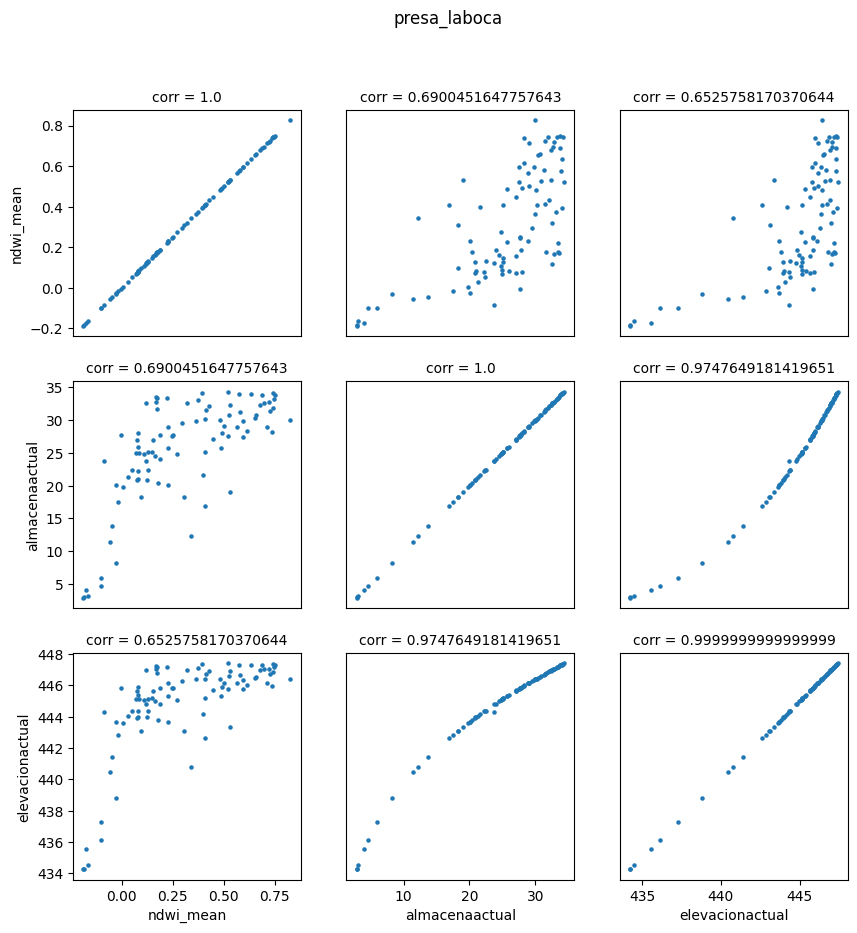

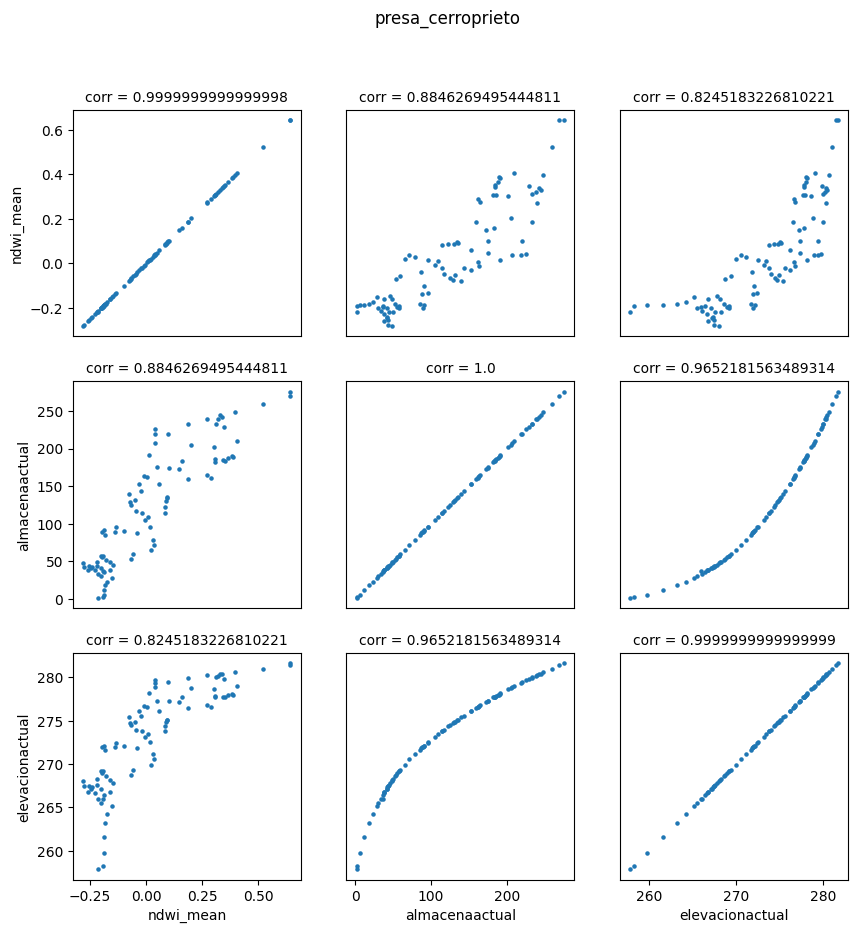

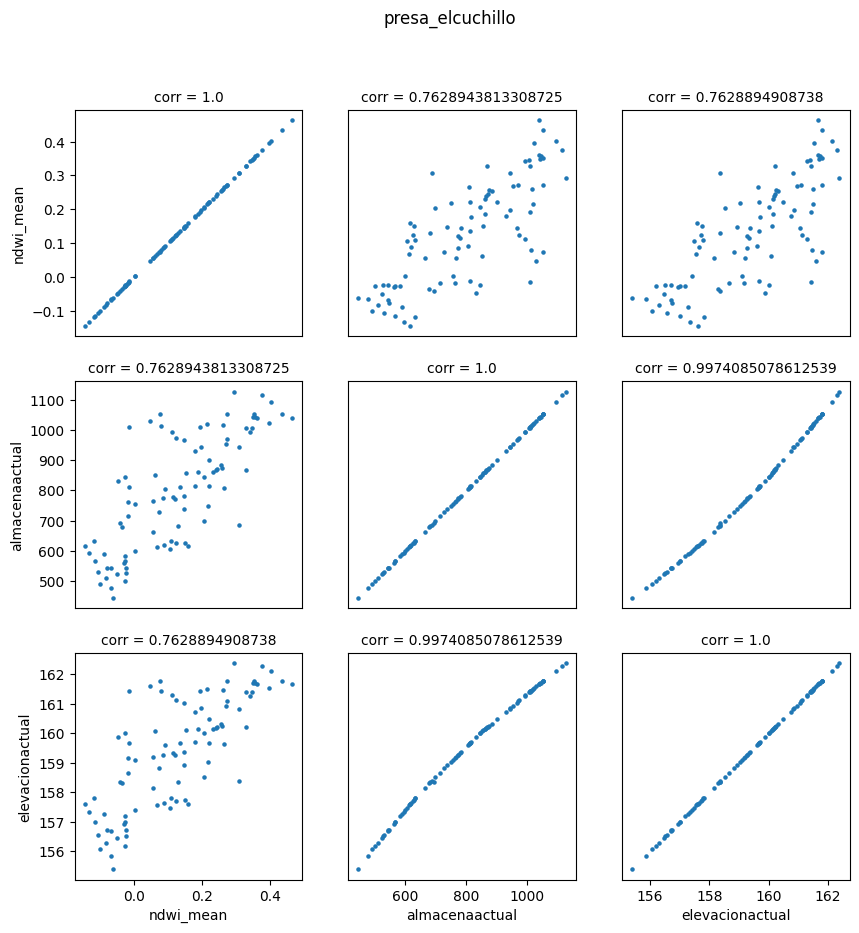

In [23]:
for city in summary.city.unique():
    dam_data = summary.loc[summary.city == city]
    dam_data.loc[:,'ndwi_mean'] = dam_data['ndwi_mean'].astype('float')
    

    cols = ['ndwi_mean', 'almacenaactual', 'elevacionactual']

    # Crear grid de subplots igual al número de posibilidades de variables (4 columnas, combinadas entre sí = 4x4)
    fig, axs = plt.subplots(len(cols), len(cols), figsize=(10,10))
    fig.suptitle(city)
    
    # Iterar entre las columnas
    for i in range(len(cols)):
        for j in range(len(cols)):
            #Plot
            axs[i,j].scatter(dam_data[cols[j]], dam_data[cols[i]], s=5)

            #Correlación
            corr, pval = stats.pearsonr(dam_data[cols[j]],dam_data[cols[i]])
            axs[i,j].set_title("corr = {}".format(corr),fontsize=10)

            # Formato - apagar las tick marks
            axs[i,j].get_xaxis().set_visible(False)
            axs[i,j].get_yaxis().set_visible(False)

            # Formato - prender las ticks de la última línea
            if i == len(cols) - 1:
                axs[i,j].get_xaxis().set_visible(True)
                axs[i,j].set_xlabel(cols[j])

            if j == 0:
                axs[i,j].get_yaxis().set_visible(True)
                axs[i,j].set_ylabel(cols[i])

/tmp/ipykernel_1098/704416682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dam_data.loc[:,'ndwi_mean'] = dam_data['ndwi_mean'].astype('float')
/tmp/ipykernel_1098/704416682.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dam_data.loc[:,'ndwi_mean'] = dam_data['ndwi_mean'].astype('float')
/tmp/ipykernel_1098/704416682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

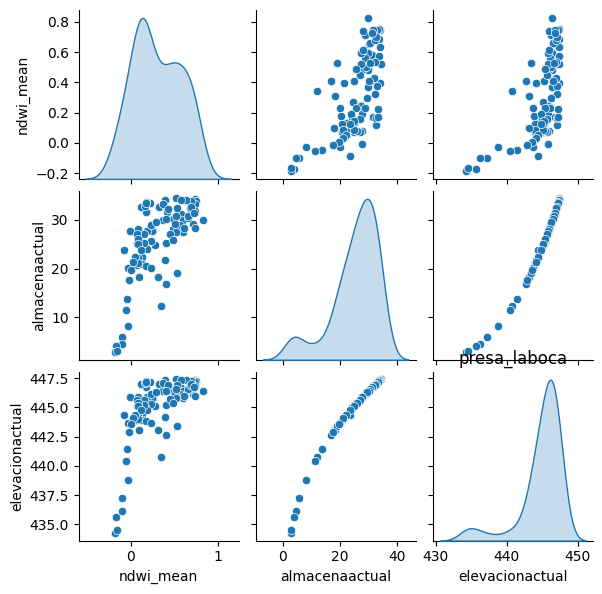

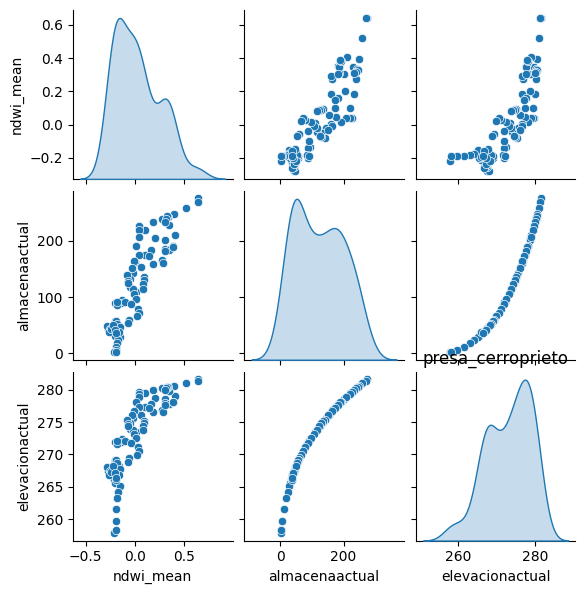

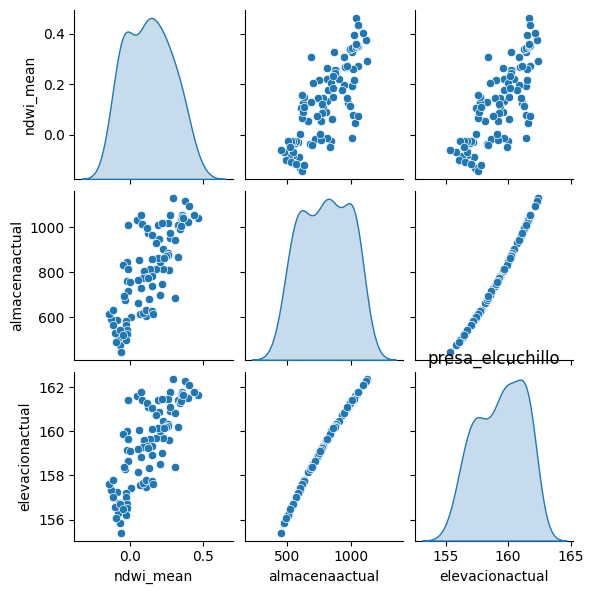

In [24]:
for city in summary.city.unique():
    dam_data = summary.loc[summary.city == city]
    dam_data.loc[:,'ndwi_mean'] = dam_data['ndwi_mean'].astype('float')
    plot_dam = dam_data[['ndwi_mean', 'almacenaactual', 'elevacionactual']]
    sns.pairplot(plot_dam, diag_kind='kde', height=2);
    plt.title(city)

## Data analysis

### Data analysis - Clean and group data

Clean and group data

In [25]:
#Clean data
columns_tokeep = ['month','year','yearmonth','city','elevacionactual','almacenaactual']
presas_analysis = presas_nuevoleon[columns_tokeep]

#Prepare data
presas_analysis.loc[:,'elevacionactual'] = presas_analysis['elevacionactual'].astype('float')
presas_analysis['almacenaactual'] = presas_analysis['almacenaactual'].astype('float')

#Empty summary dafaframe for loop
analysis_bydate = pd.DataFrame()  

#GDF for each city
for city in presas_analysis.city.unique():
    presa_gdf = presas_analysis.loc[(presas_analysis.city == city)]
    
    #GDF for each year
    for year in presa_gdf.year.unique():
        presa_gdf_year = presa_gdf.loc[(presas_analysis.year == year)]
    
        #GDF for each month in each year in city
        for month in presa_gdf_year.month.unique():
            presa_gdf_month = presa_gdf_year.loc[(presas_analysis.month == month)]

            #Group by data for that month in that city
            temp = presa_gdf_month.groupby('yearmonth').agg({'elevacionactual':np.mean,'almacenaactual':np.mean})
            temp['month'] = month
            temp['year'] = year
            temp['city'] = city

            #Concatenate
            analysis_bydate = pd.concat([analysis_bydate,temp])

#Format
analysis_bydate.reset_index(inplace=True)
analysis_bydate = analysis_bydate[['yearmonth','year','month','elevacionactual','almacenaactual','city']]
analysis_bydate = analysis_bydate.rename(columns={'elevacionactual':'elevacionactual_mean','almacenaactual':'almacenaactual_mean'})
    
#Show
print(analysis_bydate.shape)
analysis_bydate.head(2)

/tmp/ipykernel_1098/1422093885.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presas_analysis['elevacionactual'] = presas_analysis['elevacionactual'].astype('float')
/tmp/ipykernel_1098/1422093885.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presas_analysis['almacenaactual'] = presas_analysis['almacenaactual'].astype('float')


(492, 6)


,yearmonth,year,month,elevacionactual_mean,almacenaactual_mean,city
0,2021-02,21,2,446.584074,30.800889,presa_laboca
1,2021-03,21,3,446.437000,30.178267,presa_laboca


### Data analysis - Plot data

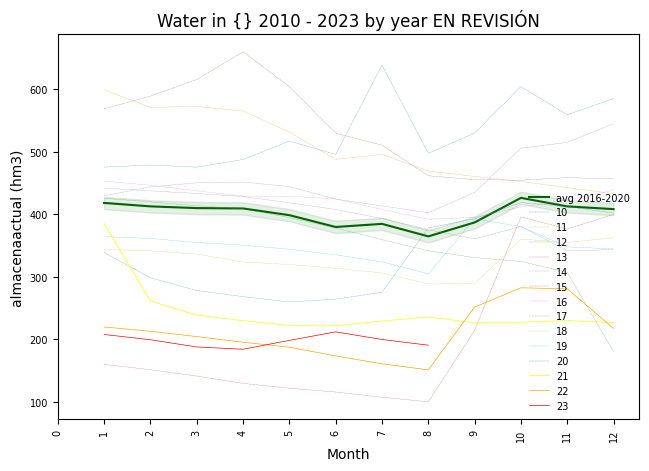

In [40]:
#Isolate data for dam
dam_analysis = analysis_bydate.copy()
dam_analysis = dam_analysis.sort_values(by=['year'])

# ---------- WHOLA DATA BY MONTH (MAIN LINE) ----------
# DATA
dam_analysis_f = dam_analysis.loc[dam_analysis.year<=20]
complete_bymonth = dam_analysis_f.groupby('month').agg({'month':np.mean,'almacenaactual_mean':np.mean})
complete_bymonth

# ---------- DATA AND CONFIDENCE INTERVAL PLOT ----------
#Confidence interval data
x = complete_bymonth.month
y = complete_bymonth.almacenaactual_mean
ci = 1.96 * np.std(y)/np.sqrt(len(x))

#Plot
fig, ax = plt.subplots(figsize=(7.5,5))
ax.plot(x,y, color = 'darkgreen',label='avg 2016-2020')
ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

# ---------- MONTHLY DATA (dotted lines) ----------

# Find all data years
available_years = list(dam_analysis['year'].unique())

#Iterate over each year
for current_year in available_years:
    #Isolating df
    dam_year = dam_analysis.loc[(dam_analysis.year == current_year)]
    dam_year = dam_year.sort_values(by=['month'])

    #Plotting
    dam_year = dam_year[['month','almacenaactual_mean']]
    
    for month in dam_year.month.unique():
        all_month = dam_year.groupby('month').agg({'almacenaactual_mean':np.mean})
        all_month.reset_index(inplace=True)
    
    x = all_month.month
    y = all_month.almacenaactual_mean

    if current_year == 21:
        plt.plot(x,y, linewidth = 0.5, label=current_year,c='yellow');        
    elif current_year == 22:
        plt.plot(x,y, linewidth = 0.5, label=current_year,c='orange');
    elif current_year == 23:
        plt.plot(x,y, linewidth = 0.5, label=current_year,c='red');
    else:
        plt.plot(x,y, '--', linewidth = 0.20, label=current_year);

# ---------- FORMAT ----------
# Format - Titles
plt.title('Water in {} 2010 - 2023 by year EN REVISIÓN')
plt.xlabel('Month')
plt.ylabel('almacenaactual (hm3)')

# Format - x ticks
# Tag all 12 months
plt.xticks(np.arange(0, 13))
# Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)

# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)

# Format - Legend
plt.legend(frameon=False,
           loc=4, 
           fontsize = 7)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndwi/water_in_{}_2010-2023_NL.svg")

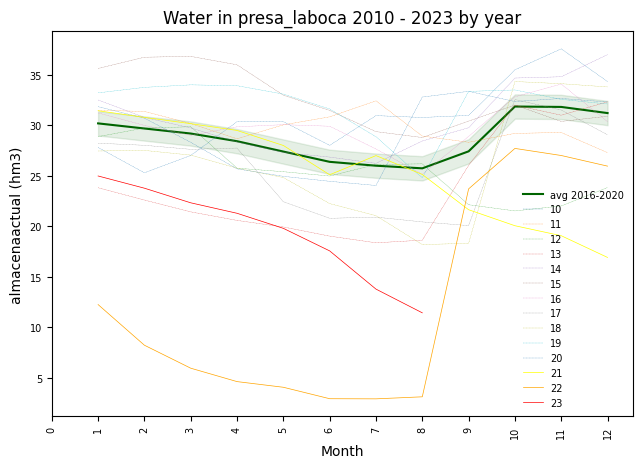

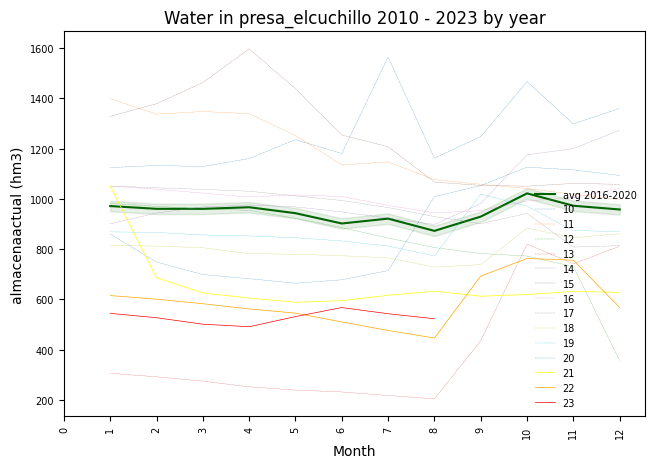

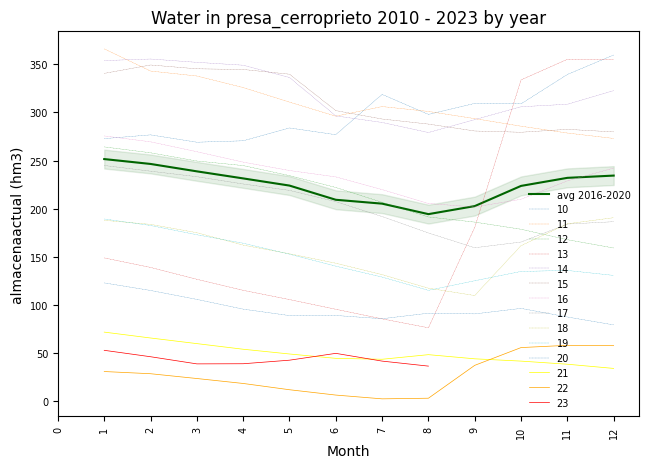

In [26]:
for city in analysis_bydate.city.unique():

    #Isolate data for dam
    dam_analysis = analysis_bydate.loc[analysis_bydate.city == city]
    dam_analysis = dam_analysis.sort_values(by=['year'])
    
    # DATA
    dam_analysis_f = dam_analysis.loc[dam_analysis.year<=20]
    complete_bymonth = dam_analysis_f.groupby('month').agg({'month':np.mean,'almacenaactual_mean':np.mean})
    complete_bymonth

    # ------- DATA AND CONFIDENCE INTERVAL PLOT -------
    #Confidence interval data
    x = complete_bymonth.month
    y = complete_bymonth.almacenaactual_mean
    ci = 1.96 * np.std(y)/np.sqrt(len(x))

    #Plot
    fig, ax = plt.subplots(figsize=(7.5,5))
    ax.plot(x,y, color = 'darkgreen',label='avg 2016-2020')
    ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

    # ---------- MONTHLY DATA (dotted lines) ----------

    # Find all data years
    available_years = list(dam_analysis['year'].unique())

    #Iterate over each year
    for current_year in available_years:
        #Isolating df
        dam_year = dam_analysis.loc[(dam_analysis.year == current_year)]
        dam_year = dam_year.sort_values(by=['month'])

        #Plotting
        dam_year = dam_year[['month','almacenaactual_mean']]
        x = dam_year.month
        y = dam_year.almacenaactual_mean

        if current_year == 21:
            plt.plot(x,y, linewidth = 0.5, label=current_year,c='yellow');        
        elif current_year == 22:
            plt.plot(x,y, linewidth = 0.5, label=current_year,c='orange');
        elif current_year == 23:
            plt.plot(x,y, linewidth = 0.5, label=current_year,c='red');
        else:
            plt.plot(x,y, '--', linewidth = 0.20, label=current_year);

    # ---------- FORMAT ----------
    # Format - Titles
    plt.title('Water in {} 2010 - 2023 by year'.format(city))
    plt.xlabel('Month')
    plt.ylabel('almacenaactual (hm3)')

    # Format - x ticks
    # Tag all 12 months
    plt.xticks(np.arange(0, 13))
    # Rotate ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(7)

    # Format - y ticks
    y = plt.gca().yaxis
    for item in y.get_ticklabels():
        item.set_size(7)

    # Format - Legend
    plt.legend(frameon=False,
               loc=4, 
               fontsize = 7)
    
    # ---------- Save Plot ----------
    if save_plots:
        plt.savefig("../../../output/figures/ndwi/water_in_{}_2010-2023.svg".format(city))

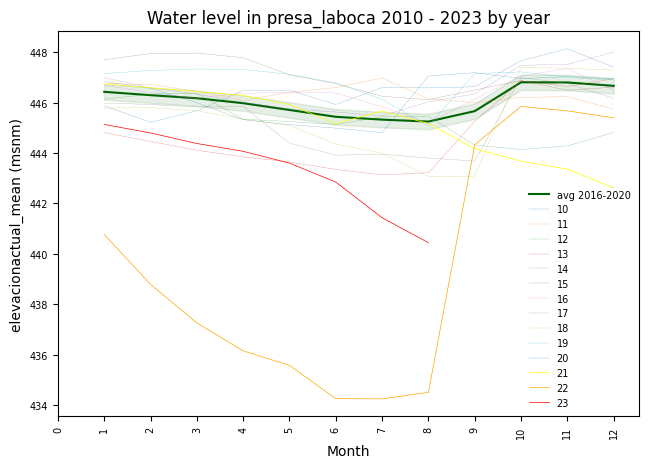

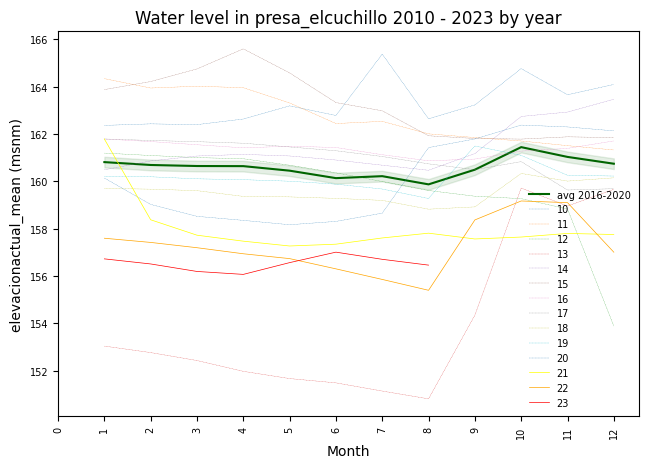

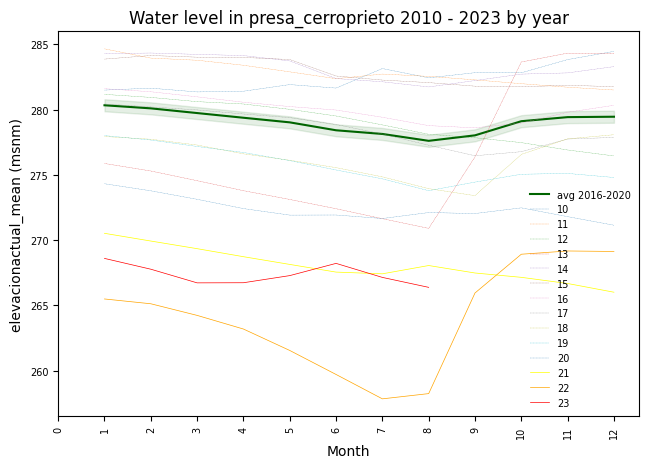

In [28]:
for city in analysis_bydate.city.unique():

    #Isolate data for dam
    dam_analysis = analysis_bydate.loc[analysis_bydate.city == city]
    dam_analysis = dam_analysis.sort_values(by=['year'])

    # ---------- Plotting whole data by month (main line) ----------
    # DATA
    dam_analysis_f = dam_analysis.loc[dam_analysis.year<=20]
    complete_bymonth = dam_analysis_f.groupby('month').agg({'month':np.mean,'elevacionactual_mean':np.mean})

    # ------- DATA AND CONFIDENCE INTERVAL PLOT -------
    #Confidence interval data
    x = complete_bymonth.month
    y = complete_bymonth.elevacionactual_mean
    ci = 1.96 * np.std(y)/np.sqrt(len(x))

    #Plot
    fig, ax = plt.subplots(figsize=(7.5,5))
    ax.plot(x,y, color = 'darkgreen',label='avg 2016-2020')
    ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

    # ---------- MONTHLY DATA (dotted lines) ----------

    # Find all data years
    available_years = list(dam_analysis['year'].unique())

    #Iterate over each year
    for current_year in available_years:
        #Isolating df
        dam_year = dam_analysis.loc[(dam_analysis.year == current_year)]
        dam_year = dam_year.sort_values(by=['month'])

        #Plotting
        dam_year = dam_year[['month','elevacionactual_mean']]
        x = dam_year.month
        y = dam_year.elevacionactual_mean

        if current_year == 21:
            plt.plot(x,y, linewidth = 0.5, label=current_year,c='yellow');  
        elif current_year == 22:
            plt.plot(x,y, linewidth = 0.5, label=current_year,c='orange');
        elif current_year == 23:
            plt.plot(x,y, linewidth = 0.5, label=current_year,c='red');
        else:
            plt.plot(x,y, '--', linewidth = 0.20, label=current_year);

    # ---------- FORMAT ----------
    # Format - Titles
    plt.title('Water level in {} 2010 - 2023 by year'.format(city))
    plt.xlabel('Month')
    plt.ylabel('elevacionactual_mean (msnm)')

    # Format - x ticks
    # Tag all 12 months
    plt.xticks(np.arange(0, 13))
    # Rotate ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(7)

    # Format - y ticks
    y = plt.gca().yaxis
    for item in y.get_ticklabels():
        item.set_size(7)

    # Format - Legend
    plt.legend(frameon=False,
               loc=4, 
               fontsize = 7)
    
    # ---------- Save Plot ----------
    if save_plots:
        plt.savefig("../../../output/figures/ndwi/height_in_{}_2010-2023.svg".format(city))

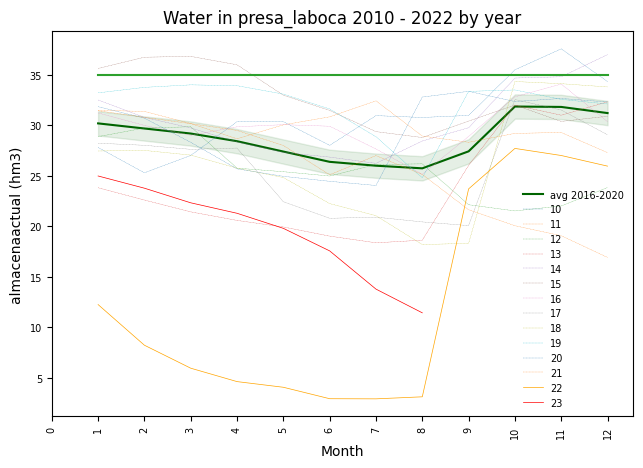

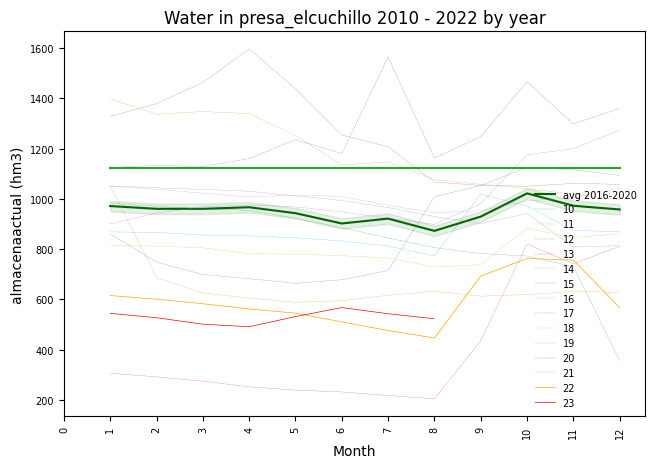

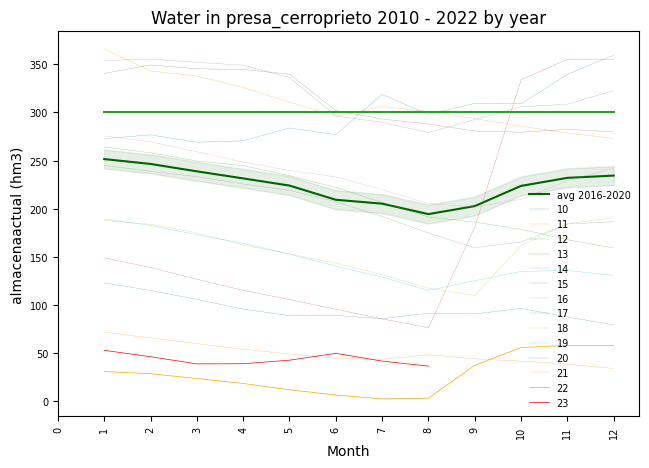

In [29]:
for city in analysis_bydate.city.unique():

    #Isolate data for dam
    dam_analysis = analysis_bydate.loc[analysis_bydate.city == city]
    dam_analysis = dam_analysis.sort_values(by=['year'])

    # ---------- Plotting whole data by month (main line) ----------
    # DATA
    dam_analysis_f = dam_analysis.loc[dam_analysis.year<=20]
    complete_bymonth = dam_analysis_f.groupby('month').agg({'month':np.mean,'almacenaactual_mean':np.mean})

    # ------- DATA AND CONFIDENCE INTERVAL PLOT -------
    #Confidence interval data
    x = complete_bymonth.month
    y = complete_bymonth.almacenaactual_mean
    ci = 1.96 * np.std(y)/np.sqrt(len(x))

    #Plot
    fig, ax = plt.subplots(figsize=(7.5,5))
    ax.plot(x,y, color = 'darkgreen',label='avg 2016-2020')
    ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

    # ---------- MONTHLY DATA (dotted lines) ----------

    # Find all data years
    available_years = list(dam_analysis['year'].unique())

    #Iterate over each year
    for current_year in available_years:
        #Isolating df
        dam_year = dam_analysis.loc[(dam_analysis.year == current_year)]
        dam_year = dam_year.sort_values(by=['month'])

        #Plotting
        dam_year = dam_year[['month','almacenaactual_mean']]
        x = dam_year.month
        y = dam_year.almacenaactual_mean

        if current_year == 22:
            plt.plot(x,y, linewidth = 0.5, label=current_year,c='orange');
        elif current_year == 23:
            plt.plot(x,y, linewidth = 0.5, label=current_year,c='red');
        else:
            plt.plot(x,y, '--', linewidth = 0.20, label=current_year);
            
    # ---------- MONTHLY DATA (dotted lines) ----------
    if city == 'presa_cerroprieto':
        namo = 300
        x = [1,2,3,4,5,6,7,8,9,10,11,12]
        y = [namo,namo,namo,namo,namo,namo,namo,namo,namo,namo,namo,namo]
        plt.plot(x,y)
    elif city == 'presa_elcuchillo':
        namo = 1123.14
        x = [1,2,3,4,5,6,7,8,9,10,11,12]
        y = [namo,namo,namo,namo,namo,namo,namo,namo,namo,namo,namo,namo]
        plt.plot(x,y)
    else:
        namo = 35
        x = [1,2,3,4,5,6,7,8,9,10,11,12]
        y = [namo,namo,namo,namo,namo,namo,namo,namo,namo,namo,namo,namo]
        plt.plot(x,y)
            
    # ---------- FORMAT ----------
    # Format - Titles
    plt.title('Water in {} 2010 - 2022 by year'.format(city))
    plt.xlabel('Month')
    plt.ylabel('almacenaactual (hm3)')

    # Format - x ticks
    # Tag all 12 months
    plt.xticks(np.arange(0, 13))
    # Rotate ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(7)

    # Format - y ticks
    y = plt.gca().yaxis
    for item in y.get_ticklabels():
        item.set_size(7)

    # Format - Legend
    plt.legend(frameon=False,
               loc=4, 
               fontsize = 7)